In [1]:
import pandas as pd
import numpy as np
import json

from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [2]:
# Load the actual data
actual = pd.read_csv('./Phase_2_data/labels_val_updated.csv')
actual = actual[['filename', 'Region_ID']]
# actual.head()

## REGION ID

In [19]:
# Load the predicted data
pred = pd.read_csv('./RegionIDTask/RegionId_test_with_filenames.csv')
pred = pred[['filename', 'Region_ID']]
# pred.head()

In [20]:
# Merge on filename
merged_df = pd.merge(actual, pred, on='filename', suffixes=('_actual', '_pred'))

# Extract actual and predicted arrays
y_true = merged_df['Region_ID_actual'].to_numpy()
y_pred = merged_df['Region_ID_pred'].to_numpy()

# Get unique classes (across actuals and preds)
actual_classes = np.unique(y_true)
pred_classes = np.unique(y_pred)

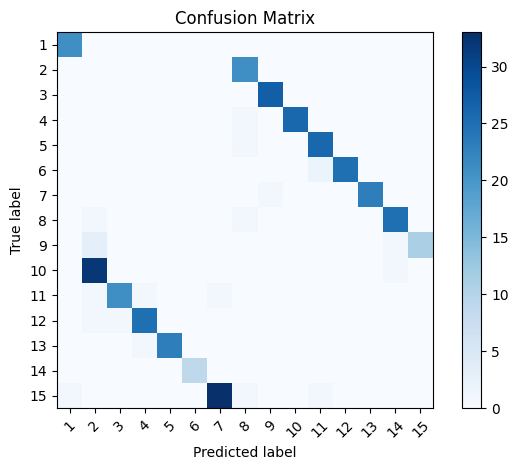

In [21]:
# Build a confusion matrix between actual and predicted (rows: actual, cols: predicted)
conf_mat = confusion_matrix(y_true, y_pred, labels=actual_classes)
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(pred_classes)), pred_classes, rotation=45)
plt.yticks(np.arange(len(actual_classes)), actual_classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [22]:

# Convert confusion matrix into a cost matrix for assignment:
# We use negative counts because the Hungarian algorithm minimizes cost, but we want to maximize matching.
cost_matrix = -conf_mat

# Solve the assignment problem (Hungarian algorithm)
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Build the mapping from predicted class → actual class
pred_to_actual_mapping = {}
for pred_idx, actual_idx in zip(col_ind, row_ind):
    pred_class = pred_classes[pred_idx]
    actual_class = actual_classes[actual_idx]
    pred_to_actual_mapping[pred_class] = actual_class

print("Recovered mapping (predicted → actual):")
for pred, act in pred_to_actual_mapping.items():
    print(f"{pred} → {act}")

# save the mapping to a npy file
np.save('pred_to_actual_mapping.npy', pred_to_actual_mapping)


Recovered mapping (predicted → actual):
1 → 1
8 → 2
9 → 3
10 → 4
11 → 5
12 → 6
13 → 7
14 → 8
15 → 9
2 → 10
3 → 11
4 → 12
5 → 13
6 → 14
7 → 15


In [23]:
# Load the mapping from npy file
pred_to_actual_mapping = np.load('pred_to_actual_mapping.npy', allow_pickle=True).item()

# Apply the mapping to the predictions
mapped_pred = np.array([pred_to_actual_mapping[p] for p in y_pred])

# Compute correlation after mapping
correlation = np.corrcoef(y_true, mapped_pred)[0, 1]
print(f"\nCorrelation between actual and mapped predictions: {correlation:.4f}")

# Compute accuracy after remapping
accuracy = np.mean(y_true == mapped_pred)
print(f"Accuracy after mapping: {accuracy * 100:.2f}%")


Correlation between actual and mapped predictions: 0.9587
Accuracy after mapping: 94.31%


In [24]:
# Save the remapped predictions
remapped_df = pd.DataFrame({
    'filename': merged_df['filename'],
    'Region_ID': mapped_pred
})
remapped_df.to_csv('./RegionIDTask/RegionId_test_with_filenames_remapped.csv', index=True, index_label="id")
print("Remapped predictions saved to './RegionIDTask/RegionId_test_with_filenames_remapped.csv'")

Remapped predictions saved to './RegionIDTask/RegionId_test_with_filenames_remapped.csv'


In [36]:
# Load mapping apply to the file
pred_to_actual_mapping = np.load('pred_to_actual_mapping.npy', allow_pickle=True).item()

print("Recovered mapping (predicted → actual):")
for pred, act in pred_to_actual_mapping.items():
    print(f"{pred} → {act}")

# Apply the mapping to the prediction
raw_pred = pd.read_csv('./RegionIDTask/testtemp=0.1_with_filenames.csv')
raw_pred['Region_ID'] = raw_pred['Region_ID'].map(lambda x: pred_to_actual_mapping[x])

raw_pred.head()
# raw_pred.drop(columns=['filename'],inplace=True)
raw_pred.to_csv("./RegionIDTask/testtemp=0.1.csv", index=False)

Recovered mapping (predicted → actual):
1 → 1
8 → 2
9 → 3
10 → 4
11 → 5
12 → 6
13 → 7
14 → 8
15 → 9
2 → 10
3 → 11
4 → 12
5 → 13
6 → 14
7 → 15


In [39]:
# cross check val acc

truth = pd.read_csv('./Phase_2_data/labels_val_updated.csv')
pred = pd.read_csv('./RegionIDTask/Remapped.csv')

merged_val = pd.merge(truth, pred, on='filename', suffixes=('_truth', '_pred'))
val_accuracy = np.mean(merged_val['Region_ID_truth'] == merged_val['Region_ID_pred'])
print("Validation Accuracy:", val_accuracy)



Validation Accuracy: 0.943089430894309


# ANGLE

In [13]:
# calculate pipelined acc
import pandas as pd
import numpy as np

truth = pd.read_csv("./AngleTask/AngleDataset/val_label.csv")
pred = pd.read_csv("./AngleTask/valtemp=0.01.csv")

merged_val = pd.merge(truth, pred, on='filename', suffixes=('_truth', '_pred'))

def mae(pred, truth):
    diff = np.abs(pred - truth)
    diff = np.minimum(diff, 360 - diff)
    return np.mean(diff)

mae_score = mae(merged_val['predicted_angle'], merged_val['angle'])
print("MAE: ", mae_score)
print("score: ", 1/(1 + mae_score))

MAE:  21.18259010873836
score:  0.045080398415966366


In [23]:
# convert the file into correct form
FILE = "./AngleTask/valtemp=1.csv"
pred = pd.read_csv(FILE)

error = pred['error']
truth = pred['true_angle']
pred = pred[['filename','predicted_angle']]

pred.rename(columns={'predicted_angle':'angle'}, inplace=True)

=== Error Statistics ===
Mean Error   : 21.3830
Median Error : 11.5822
Std Dev      : 29.2909
Max Error    : 177.4820
Min Error    : 0.0163


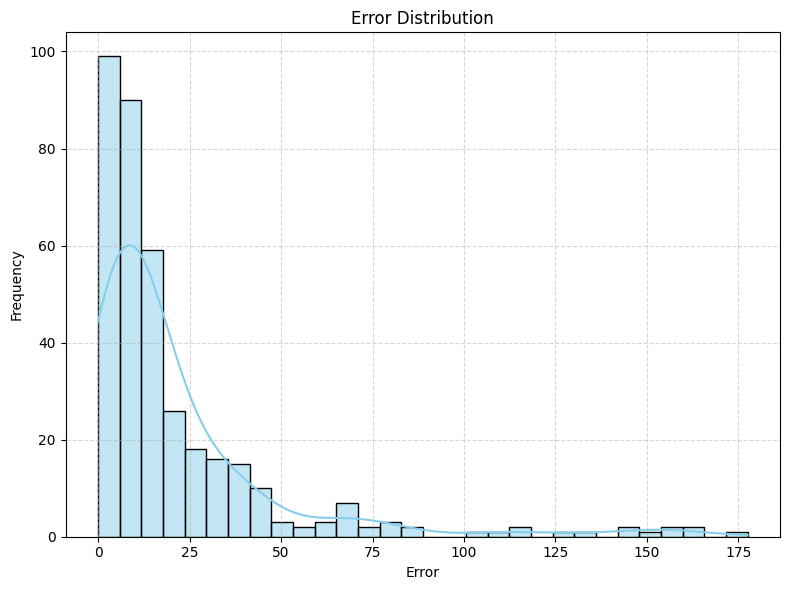

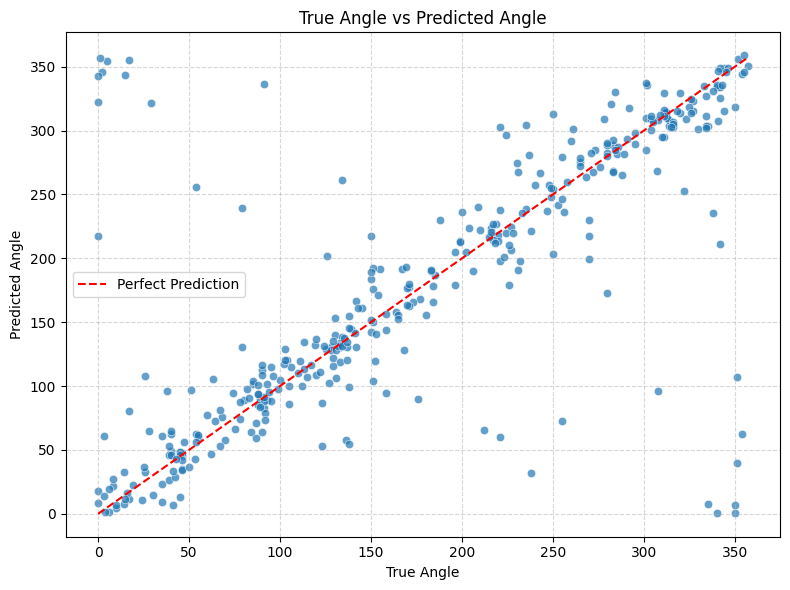

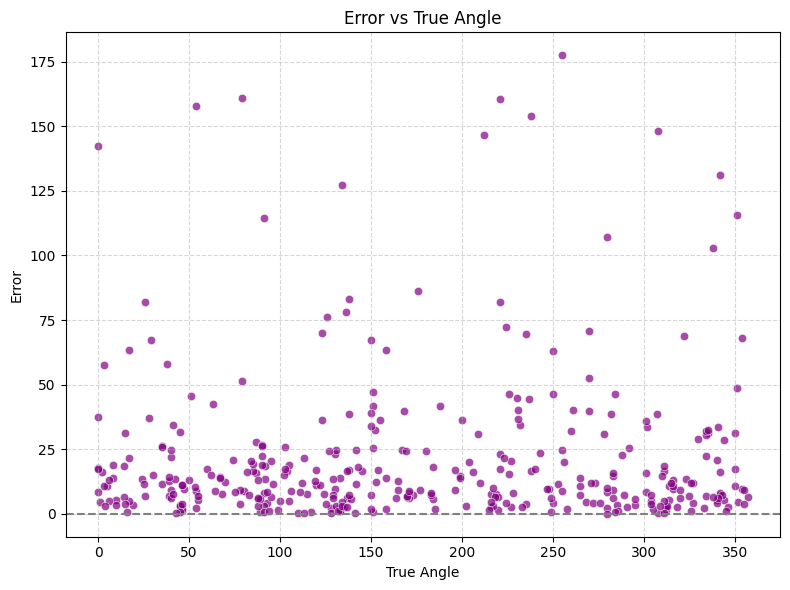

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
mean_error = error.mean()
median_error = error.median()
std_error = error.std()
max_error = error.max()
min_error = error.min()

print("=== Error Statistics ===")
print(f"Mean Error   : {mean_error:.4f}")
print(f"Median Error : {median_error:.4f}")
print(f"Std Dev      : {std_error:.4f}")
print(f"Max Error    : {max_error:.4f}")
print(f"Min Error    : {min_error:.4f}")

# Step 5: Plot histogram of error
plt.figure(figsize=(8, 6))
sns.histplot(error, bins=30, kde=True, color='skyblue')
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('./AngleTask/error_histogram.png')
plt.show()
plt.close()

# Step 6: Scatter plot of true vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=truth, y=pred['angle'], alpha=0.7)
plt.plot([truth.min(), truth.max()], [truth.min(), truth.max()], 'r--', label='Perfect Prediction')
plt.title('True Angle vs Predicted Angle')
plt.xlabel('True Angle')
plt.ylabel('Predicted Angle')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('./AngleTask/true_vs_predicted.png')
plt.show()
plt.close()

# Step 7: Error vs True Angle plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=truth, y=error, alpha=0.7, color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Error vs True Angle')
plt.xlabel('True Angle')
plt.ylabel('Error')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('./AngleTask/error_vs_true_angle.png')
plt.show()
plt.close()


In [25]:
pred[['filename', 'angle']].to_csv(FILE, index=True, index_label="id")

print(f"\nSaved reduced CSV with filename and angle to: {FILE}")



Saved reduced CSV with filename and angle to: ./AngleTask/valtemp=1.csv


# LAT-LONG 

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler  

# create a scalar to scale values to between 1 and 0 (lineraly) (common scaler for uniformity)
common_scaler = MinMaxScaler()
train = pd.read_csv("Phase_2_data/labels_train_updated.csv")
val = pd.read_csv("Phase_2_data/labels_val_updated.csv")

train.head()

,filename,timestamp,latitude,longitude,angle,Region_ID
0,img_0000.jpg,15:03,219698,144782,133,2
1,img_0001.jpg,15:05,219844,144621,312,2
2,img_0002.jpg,15:05,219844,144621,359,2
3,img_0003.jpg,17:11,219514,145016,131,2
4,img_0004.jpg,17:00,220182,144211,45,2


In [2]:

# train.head()

# remove timestamp field
train.drop(columns=["timestamp"], inplace=True)
val.drop(columns=["timestamp"], inplace=True)

# remove outlier from the latitude and longitude
# Remove outliers in latitude and longitude using the IQR method for train data
for col in ['latitude', 'longitude']:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    train = train[(train[col] >= Q1 - 1.5 * IQR) & (train[col] <= Q3 + 1.5 * IQR)]

# Remove outliers in latitude and longitude using the IQR method for val data
for col in ['latitude', 'longitude']:
    Q1 = val[col].quantile(0.25)
    Q3 = val[col].quantile(0.75)
    IQR = Q3 - Q1
    val = val[(val[col] >= Q1 - 1.5 * IQR) & (val[col] <= Q3 + 1.5 * IQR)]

# create a scaler to scale values to between 0 and 1 (linearly) (common scaler for uniformity)
lat_scaler = MinMaxScaler()
long_scaler = MinMaxScaler()

# Fit and transform the latitude and longitude columns for train and transform for val data
train[['latitude']] = lat_scaler.fit_transform(train[['latitude']])
val[['latitude']] = lat_scaler.transform(val[['latitude']])

train[['longitude']] = long_scaler.fit_transform(train[['longitude']])
val[['longitude']] = long_scaler.transform(val[['longitude']])



In [3]:
import joblib

train.head()
val.head()

# Save the scalar for future use and load and invert and cross check to se if it works
# Save the scaler to disk
joblib.dump(lat_scaler, 'lat_scaler.pkl')
joblib.dump(long_scaler, 'long_scaler.pkl')

# Load the scaler back for verification
loaded_lat_scaler = joblib.load('lat_scaler.pkl')
loaded_long_scaler = joblib.load('long_scaler.pkl')

# Invert the scaling on the train data for latitude and longitude
check_lat = loaded_lat_scaler.inverse_transform(train[['latitude']])
check_long = loaded_long_scaler.inverse_transform(train[['longitude']])
print("First 5 rows of the inverted latitude (test):")
print(check_lat[:5])
print("First 5 rows of the inverted longitude (test):")
print(check_long[:5])

First 5 rows of the inverted latitude (test):
[[219698.]
 [219844.]
 [219844.]
 [219514.]
 [220182.]]
First 5 rows of the inverted longitude (test):
[[144782.]
 [144621.]
 [144621.]
 [145016.]
 [144211.]]


In [4]:
train.to_csv("LatLongTask/LatLongDataset/train_label.csv", index=False)
val.to_csv("LatLongTask/LatLongDataset/val_label.csv", index=False)

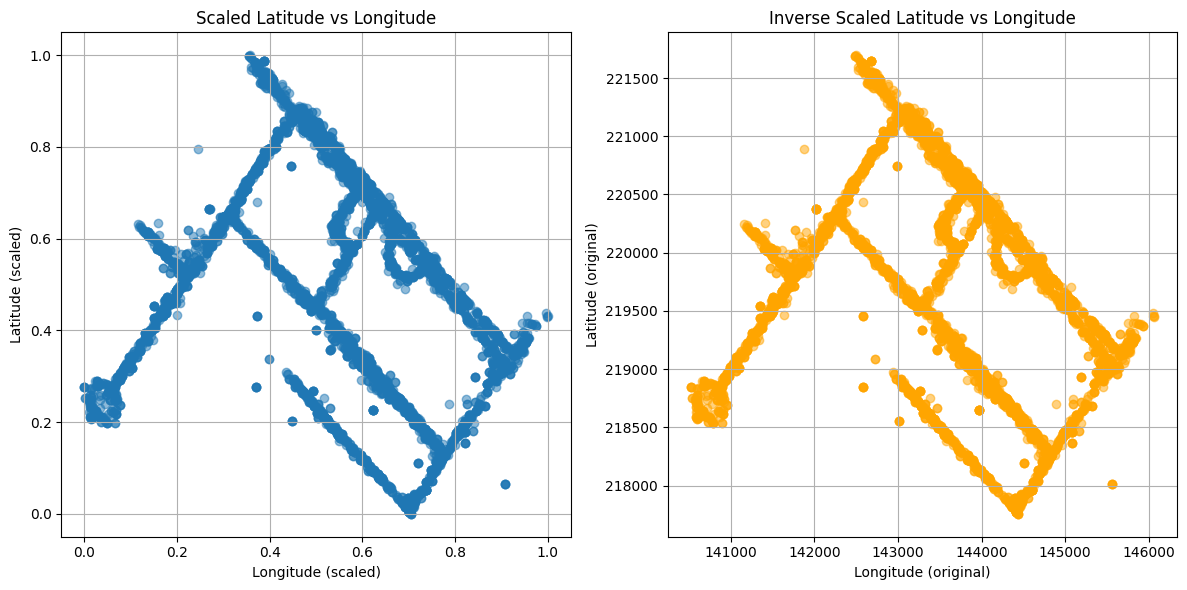

In [5]:
# plot the lat and log to verify
import matplotlib.pyplot as plt

# Plot scaled vs inverse-scaled latitude and longitude side by side

plt.figure(figsize=(12, 6))

# Plot for scaled data
plt.subplot(1, 2, 1)
plt.scatter(train['longitude'], train['latitude'], alpha=0.5)
plt.xlabel("Longitude (scaled)")
plt.ylabel("Latitude (scaled)")
plt.title("Scaled Latitude vs Longitude")
plt.grid(True)

# Plot for the inverse scaled (original) data
plt.subplot(1, 2, 2)
plt.scatter(loaded_long_scaler.inverse_transform(train[['longitude']]).flatten(),
            loaded_lat_scaler.inverse_transform(train[['latitude']]).flatten(),
            alpha=0.5, color='orange')
plt.xlabel("Longitude (original)")
plt.ylabel("Latitude (original)")
plt.title("Inverse Scaled Latitude vs Longitude")
plt.grid(True)

plt.tight_layout()
plt.show()